<a href="https://colab.research.google.com/github/wenqiglantz/hands-on-llamaindex/blob/main/04_finetune_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Embedding Model for NVIDIA SEC Filing Analysis

By fine-tuning our embedding model, we enhance our system’s ability to retrieve the most relevant documents, ensuring that our RAG pipeline performs at its best.

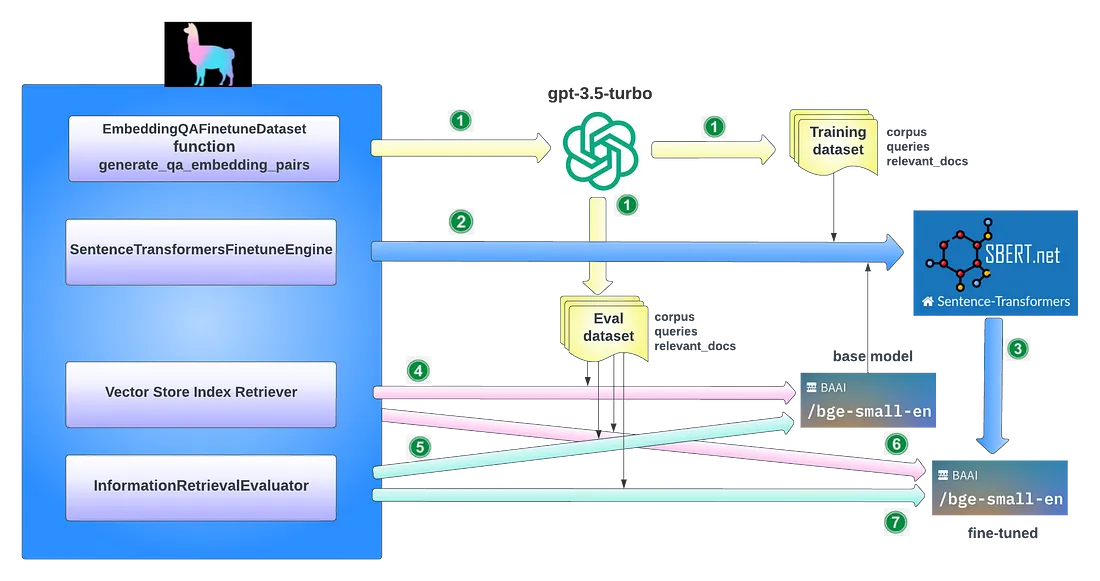

Detailed steps:

1. Automate data generation for the evaluation and training datasets by calling `EmbeddingQAFinetuneDataset`'s function `generate_qa_embedding_pairs`.
2. Construct `SentenceTransformersFinetuneEngine` by passing in the base model and the training dataset, then call its finetune function to train the base model.
3. Create the fine-tuned model.
4. Call vector store index retriever to retrieve relevant nodes and assess the hit rate for the base model.
5. Call `InformationRetrievalEvaluator` to evaluate the base model.
6. Call vector store index retriever to retrieve relevant nodes and assess the hit rate for the fine-tuned model.
7. Call `InformationRetrievalEvaluator` to evaluate the fine-tuned model.

## Installation and Configuration

In [1]:
%pip install -q llama-index-llms-openai
%pip install -q llama-index-embeddings-openai
%pip install -q llama-index-embeddings-huggingface
%pip install -q llama-index-finetuning
%pip install -q llama-index-finetuning-callbacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.0/631.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
!pip install -q llama_index pypdf sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 29.5 MB/s eta 0:00:00


In [3]:
import json
import openai
import os

from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import MetadataMode
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    Response
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import logging, sys
import nest_asyncio

nest_asyncio.apply()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [5]:
!curl https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/4e9abe7b-fdc7-4cd2-8487-dc3a99f30e98.pdf --output nvidia-sec-10k-2022.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1541k  100 1541k    0     0  2694k      0 --:--:-- --:--:-- --:--:-- 2699k


## Generate dataset

### Load corpus

Load corpus function, can be called for either training dataset (first 90 pages) or eval dataset (the rest of the 79 pages).  for_training flag defaults to false.

In [6]:
def load_corpus(docs, for_training=False, verbose=False):
    parser = SentenceSplitter()
    if for_training:
        nodes = parser.get_nodes_from_documents(docs[:90], show_progress=verbose)
    else:
        nodes = parser.get_nodes_from_documents(docs[91:], show_progress=verbose)

    if verbose:
        print(f'Parsed {len(nodes)} nodes')

    return nodes

In [7]:
SEC_FILE = ['nvidia-sec-10k-2022.pdf']

print(f"Loading files {SEC_FILE}")

reader = SimpleDirectoryReader(input_files=SEC_FILE)
docs = reader.load_data()
print(f'Loaded {len(docs)} docs')

train_nodes = load_corpus(docs, for_training=True, verbose=True)
val_nodes = load_corpus(docs, for_training=False, verbose=True)

Loading files ['nvidia-sec-10k-2022.pdf']
Loaded 169 docs


Parsing nodes:   0%|          | 0/90 [00:00<?, ?it/s]

Parsed 97 nodes


Parsing nodes:   0%|          | 0/78 [00:00<?, ?it/s]

Parsed 84 nodes


### Generate synthetic queries

In [8]:
from llama_index.finetuning import generate_qa_embedding_pairs
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
from llama_index.llms.openai import OpenAI

Now let's generate our dataset for training and evaluation.

In [9]:
from google.colab import userdata

# set OpenAI API key in environment variable
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

llm=OpenAI(model="gpt-3.5-turbo-0613")

train_dataset = generate_qa_embedding_pairs(train_nodes, llm=llm)
val_dataset = generate_qa_embedding_pairs(val_nodes, llm=llm)

train_dataset.save_json("train_dataset.json")
val_dataset.save_json("val_dataset.json")

100%|██████████| 84/84 [01:15<00:00,  1.11it/s]


In [10]:
train_dataset = EmbeddingQAFinetuneDataset.from_json("train_dataset.json")
val_dataset = EmbeddingQAFinetuneDataset.from_json("val_dataset.json")

## Fine-tune embedding model

In [11]:
from llama_index.finetuning import SentenceTransformersFinetuneEngine

In [12]:
finetune_engine = SentenceTransformersFinetuneEngine(
    train_dataset,
    model_id="BAAI/bge-small-en",
    model_output_path="test_model",
    val_dataset=val_dataset,
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
finetune_engine.finetune()

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
embed_model = finetune_engine.get_finetuned_model()

In [15]:
embed_model

HuggingFaceEmbedding(model_name='test_model', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7dab2d63dea0>, tokenizer_name='test_model', max_length=512, pooling=<Pooling.CLS: 'cls'>, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None)

## Evaluate fine-tuned model

In [16]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import VectorStoreIndex
from llama_index.core.schema import TextNode
from tqdm.notebook import tqdm
import pandas as pd

In [17]:
def evaluate(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
    corpus = dataset.corpus
    queries = dataset.queries
    relevant_docs = dataset.relevant_docs

    nodes = [TextNode(id_=id_, text=text) for id_, text in corpus.items()]
    index = VectorStoreIndex(nodes, embed_model=embed_model, show_progress=True)
    retriever = index.as_retriever(similarity_top_k=top_k)

    eval_results = []
    for query_id, query in tqdm(queries.items()):
        retrieved_nodes = retriever.retrieve(query)
        retrieved_ids = [node.node.node_id for node in retrieved_nodes]
        expected_id = relevant_docs[query_id][0]
        is_hit = expected_id in retrieved_ids  # assume 1 relevant doc

        eval_result = {
            "is_hit": is_hit,
            "retrieved": retrieved_ids,
            "expected": expected_id,
            "query": query_id,
        }
        eval_results.append(eval_result)
    return eval_results

In [31]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from sentence_transformers import SentenceTransformer
from pathlib import Path

def evaluate_st(
    dataset,
    model_id,
    name,
):
    corpus = dataset.corpus
    queries = dataset.queries
    relevant_docs = dataset.relevant_docs

    evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs, name=name)

    model = SentenceTransformer(model_id)
    output_path = "results/"
    Path(output_path).mkdir(exist_ok=True, parents=True)
    return evaluator(model, output_path=output_path)

### Run Evals

#### OpenAI

In [19]:
ada = OpenAIEmbedding()
ada_val_results = evaluate(val_dataset, ada)

Generating embeddings:   0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

In [ ]:
df_ada = pd.DataFrame(ada_val_results)

In [ ]:
hit_rate_ada = df_ada['is_hit'].mean()
hit_rate_ada

#### BAAI/bge-small-en

In [ ]:
bge = "local:BAAI/bge-small-en"
bge_val_results = evaluate(val_dataset, bge)

In [ ]:
df_bge = pd.DataFrame(bge_val_results)

In [ ]:
hit_rate_bge = df_bge['is_hit'].mean()
hit_rate_bge

In [32]:
evaluate_st(val_dataset, "BAAI/bge-small-en", name='bge')

0.6355149436368012

If you run into error at this step, be sure to check if you have "results" folder created at your project root, if not, make sure to create it and re-run this step.

#### Fine-tuned model

In [26]:
finetuned = "local:test_model"
val_results_finetuned = evaluate(val_dataset, finetuned)

Generating embeddings:   0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

In [27]:
df_finetuned = pd.DataFrame(val_results_finetuned)

In [28]:
hit_rate_finetuned = df_finetuned['is_hit'].mean()
hit_rate_finetuned

0.8511904761904762

In [33]:
evaluate_st(val_dataset, "test_model", name='finetuned')

0.6943243799411525

### Summary of results

#### Hit rate

In [34]:
df_ada['model'] = 'ada'
df_bge['model'] = 'bge'
df_finetuned['model'] = 'fine_tuned'

In [35]:
df_all = pd.concat([df_ada, df_bge, df_finetuned])
df_all.groupby('model').mean('is_hit')

,is_hit
model,
ada,0.922619
bge,0.839286
fine_tuned,0.851190


#### InformationRetrievalEvaluator

In [36]:
df_st_bge = pd.read_csv('results/Information-Retrieval_evaluation_bge_results.csv')
df_st_finetuned = pd.read_csv('results/Information-Retrieval_evaluation_finetuned_results.csv')

df_st_bge['model'] = 'bge'
df_st_finetuned['model'] = 'fine_tuned'
df_st_all = pd.concat([df_st_bge, df_st_finetuned])
df_st_all = df_st_all.set_index('model')
df_st_all

,epoch,steps,cos_sim-Accuracy@1,cos_sim-Accuracy@3,cos_sim-Accuracy@5,cos_sim-Accuracy@10,cos_sim-Precision@1,cos_sim-Recall@1,cos_sim-Precision@3,cos_sim-Recall@3,...,dot_score-Recall@1,dot_score-Precision@3,dot_score-Recall@3,dot_score-Precision@5,dot_score-Recall@5,dot_score-Precision@10,dot_score-Recall@10,dot_score-MRR@10,dot_score-NDCG@10,dot_score-MAP@100
model,,,,,,,,,,,,,,,,,,,,,
bge,-1,-1,0.494048,0.714286,0.815476,0.898810,0.494048,0.494048,0.238095,0.714286,...,0.494048,0.238095,0.714286,0.163095,0.815476,0.089881,0.898810,0.630806,0.695790,0.635515
fine_tuned,-1,-1,0.577381,0.750000,0.851190,0.934524,0.577381,0.577381,0.250000,0.750000,...,0.577381,0.250000,0.750000,0.170238,0.851190,0.093452,0.934524,0.691638,0.750097,0.694324
